In [1]:

import cv2
import base64
import matplotlib.pyplot as plt
import time
from matplotlib.gridspec import GridSpec
import os
import numpy as np
import json
from IPython.display import clear_output
from tqdm import tqdm
from PIL import Image
import glob
import random
from sklearn.metrics.pairwise import cosine_similarity
from Resnet import ResNet18Embedder

In [2]:


from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
from PIL import Image



model_name="Qwen/Qwen2-VL-2B-Instruct"
model_name="Qwen/Qwen2-VL-7B-Instruct"

# default: Load the model on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
   model_name , torch_dtype="auto", device_map="auto"
)
processor = AutoProcessor.from_pretrained(
  model_name 
)

/home/setup/miniconda3/envs/vision/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


In [3]:
embedder = ResNet18Embedder(device="cpu")

/home/setup/miniconda3/envs/vision/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/setup/miniconda3/envs/vision/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def load_image_and_array(path):
    img=cv2.imread(path)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img)
    return img, (img_pil)


def get_most_similar_image(embed,annotated_embeddings,annotated_images,
                           annotated_img_path_list):
    embed_list_np = np.array(annotated_embeddings)  # リストなら先に NumPy 配列に変換する
    sim_list = cosine_similarity(
        embed.reshape(1, -1),  # (1, d)
        embed_list_np          # (N, d)
    )[0]                       # 結果は (1, N) なので [0] で (N,) にする

    most_similar_index = np.argmax(sim_list)
    most_similar_image = annotated_images[most_similar_index]
    return most_similar_image, annotated_img_path_list[most_similar_index], sim_list[most_similar_index]



In [5]:
img_dir="../private_data/out_image_data_w_gpt_annot"
img_path_list=glob.glob(img_dir+"/*.jpg")

In [6]:
#アノテーション済みデータの読み込み
annotated_img_path_list = []
unannotated_img_path_list = []
for img_path in img_path_list:
    annot_path=img_path.replace("jpg","txt")
    if os.path.exists(annot_path):
        annotated_img_path_list.append(img_path)
    else:
        unannotated_img_path_list.append(img_path)

annotated_images=[]
annotated_embeddings=[]

for img_path in tqdm(annotated_img_path_list):
    img,img_pil=load_image_and_array(img_path)
    annotated_images.append(img_pil)
    annotated_embeddings.append(embedder(img=img_pil))


100%|██████████| 254/254 [00:05<00:00, 46.47it/s]


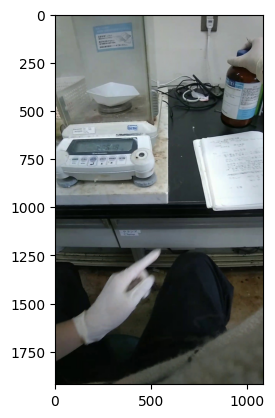

In [17]:
random_img_path=random.choice(unannotated_img_path_list)

img,img_pil=load_image_and_array(random_img_path)
embed = embedder(img=img_pil)

most_similar_image,similar_image_path, similarity = get_most_similar_image(
    embed,annotated_embeddings,annotated_images,annotated_img_path_list)


plt.imshow(img)

- 左手で薬包紙を持っている｡
- 右手で透明なサンプル瓶を持っている｡
- 電子天秤があり､表示は「-0.300 g」となっている｡
- 画面右側のホットプレートには､白い液体の入ったサンプル瓶が置かれている｡


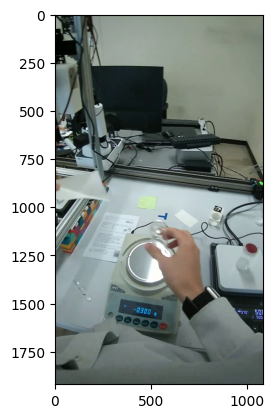

In [18]:
plt.imshow(most_similar_image,),similarity

similar_annotation_path=similar_image_path.replace("jpg","txt")
with open(similar_annotation_path) as f:
    similar_annotation=f.read()

print(similar_annotation)

In [9]:
# Messages containing multiple images and a text query
messages = [
    {
        "role": "user",
        "content": [
            #{"type": "image", "image": f"{similar_image_path}"},
            {"type": "image", "image": f"{random_img_path}"},
            #{"type": "text", "text": f"1枚目の画像のアノテーションは次の通りである: {similar_annotation}\n\nこの記述も参考にしながら､2枚目の画像についての説明を生成しなさい｡"},
            {"type": "text", "text": f"化学実験の様子です｡映っているものを箇条書きで出力"},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference
generated_ids = model.generate(**inputs, max_new_tokens=1280)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)


['1. 化学実験の様子が映っています。\n2. デジタル天秤が設置されています。\n3. 天秤の上には、試料が置かれています。\n4. 天秤の右側には、他の測定機器が配置されています。\n5. 背景には、実験室の設備や機器が見えます。']


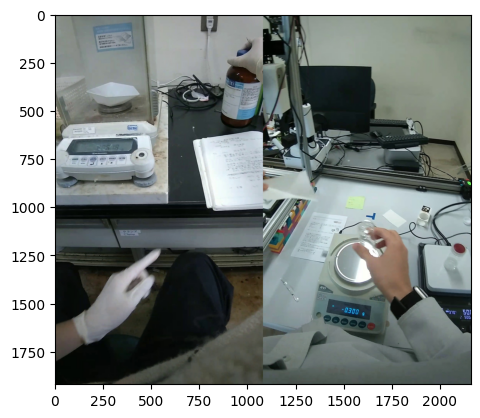

In [19]:


#二枚の画像を左右に並べて統合した画像を作成
combined_img = Image.new("RGB", (img_pil.width + most_similar_image.width, img_pil.height))
combined_img.paste(img_pil, (0, 0))
combined_img.paste(most_similar_image, (img_pil.width, 0))

plt.imshow(combined_img)

In [11]:


#推論関数
def process_image(
    model,processor,
    image,
query="中身を解析して",
max_new_tokens=128,
):

    # 画像の準備
    #image = Image.open(img_path)

    # メッセージの準備
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                },
                {"type": "text", "text": query},
            ],
        }
    ]

    # 入力の準備
    text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(
        text=[text_prompt], 
        images=[image], 
        padding=True, 
        return_tensors="pt"
    )
    inputs = inputs.to("cuda")

    # 推論の実行
    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(inputs.input_ids, output_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    return output_text

#推論
query=f"右半分の画像のアノテーション文は次のとおりである: {similar_annotation}\n\n同様の形式で､左半分の画像についてのアノテーションを生成しなさい"
text=process_image(model,processor,combined_img,query)

In [12]:
print(text[0])
print(similar_annotation)

左半分の画像のアノテーション文は次のとおりである: - 左手でアルミパウチを掴んでいる。 - 右手で異なるアルミパウチを掴んでいる。
- 左手でアルミパウチを掴んでいる｡
- 右手で異なるアルミパウチを掴んでいる｡
